In [1]:
# Import necessary libraries for data handling, visualization, and Kaggle access.
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Download the dataset from Kaggle and print the path to the files.
path = kagglehub.dataset_download("purushottamnawale/materials")
print("Path to dataset files:", path)

# Load the dataset as a pandas DataFrame.
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "purushottamnawale/materials",
    "material.csv"
)
print(df.head())  # Display the first few rows of the dataset.

Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\purushottamnawale\materials\versions\4
                         Material   Su   Sy       E      G   mu    Ro   Use
0   ANSI Steel SAE 1015 as-rolled  421  314  207000  79000  0.3  7860  True
1  ANSI Steel SAE 1015 normalized  424  324  207000  79000  0.3  7860  True
2    ANSI Steel SAE 1015 annealed  386  284  207000  79000  0.3  7860  True
3   ANSI Steel SAE 1020 as-rolled  448  331  207000  79000  0.3  7860  True
4  ANSI Steel SAE 1020 normalized  441  346  207000  79000  0.3  7860  True


In [2]:
# Display information about the DataFrame, including columns, data types, and missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Material  1552 non-null   object 
 1   Su        1552 non-null   int64  
 2   Sy        1552 non-null   int64  
 3   E         1552 non-null   int64  
 4   G         1552 non-null   int64  
 5   mu        1552 non-null   float64
 6   Ro        1552 non-null   int64  
 7   Use       1552 non-null   bool   
dtypes: bool(1), float64(1), int64(5), object(1)
memory usage: 86.5+ KB


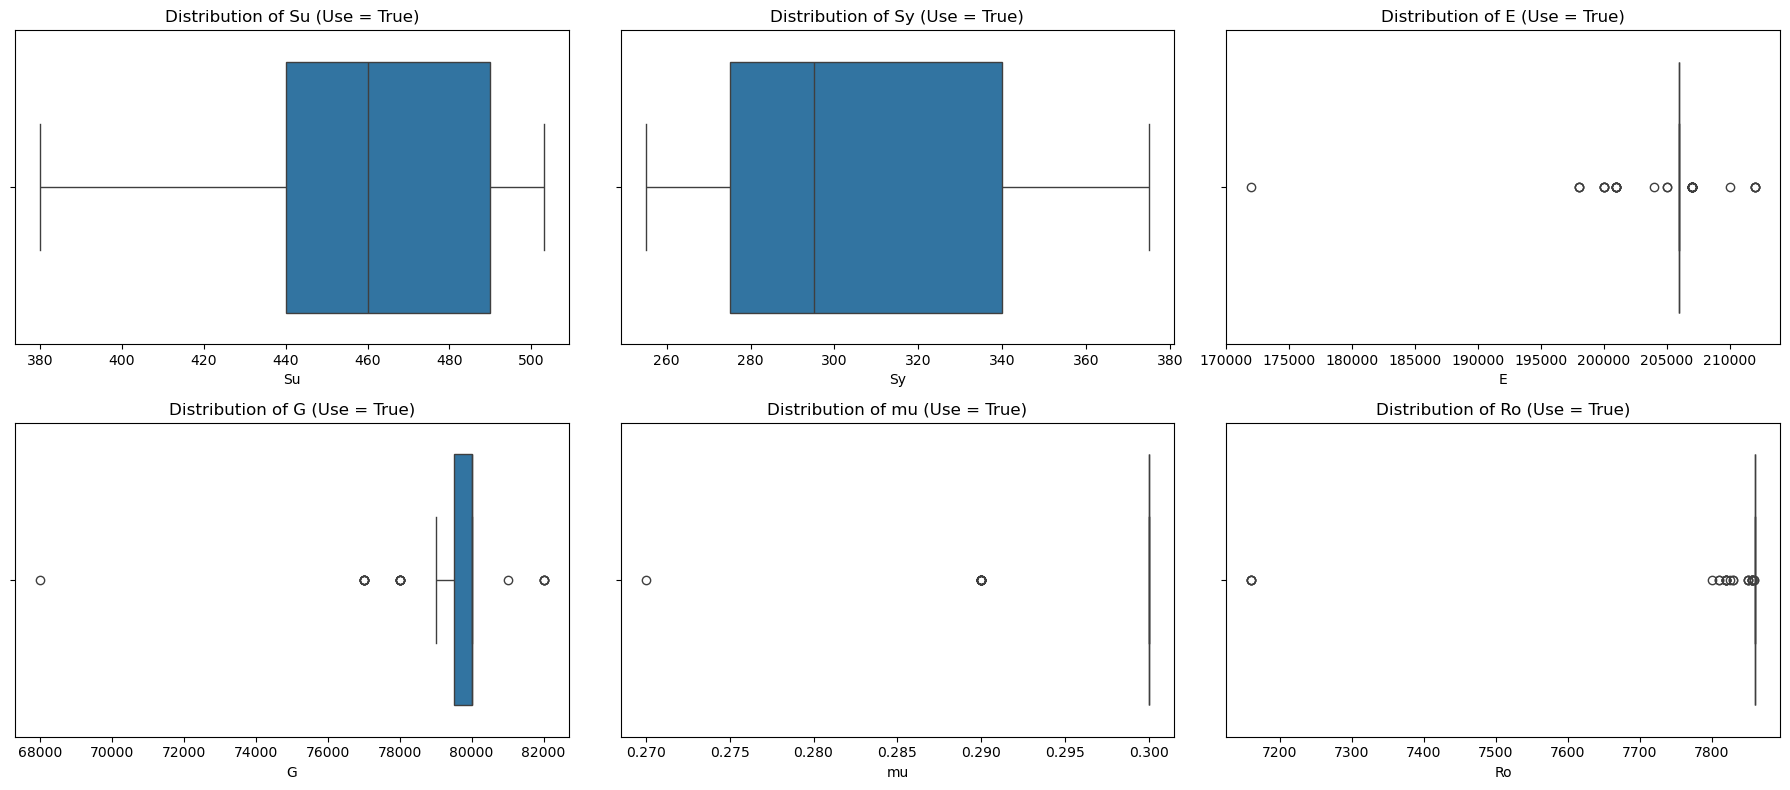

In [3]:
# Define the features to analyze.
features = ['Su', 'Sy', 'E', 'G', 'mu', 'Ro']

# Filter the DataFrame to only include rows where 'Use' is True (materials suitable for use).
df_true = df[df['Use'] == True]  

# Create a 2x3 grid of subplots for boxplots of each feature.
fig, axes = plt.subplots(2, 3, figsize=(18, 8)) 

# Flatten axes array for easy iteration.
axes = axes.flatten()

# Plot a boxplot for each feature to visualize its distribution.
for i, feature in enumerate(features):
    sns.boxplot(x=df_true[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} (Use = True)')
    axes[i].set_xlabel(feature)
plt.savefig("Distribution_of_features_usable_materials.png", dpi=300)   
plt.tight_layout()
plt.show()

In [4]:
# Import scikit-learn modules for machine learning.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, r2_score
from sklearn.model_selection import train_test_split

# Select features and target variable.
X = df[['Su', 'Sy', 'E', 'G', 'mu', 'Ro']] # Features (mechanical properties)
y = df['Use'] # Target (whether the material is suitable for use)
y = y.astype('int')  # Convert boolean to integer for classification

# Split data into training and test sets (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 100)

# Train a Random Forest Classifier on the training data.
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict on the test set.
y_pred = model.predict(X_test)

# Print F1 score and accuracy to evaluate the model.
print("F1 score: ", f1_score(y_pred, y_test))
print("Accuracy: ", accuracy_score(y_pred, y_test))

F1 score:  0.9642857142857143
Accuracy:  0.9935691318327974


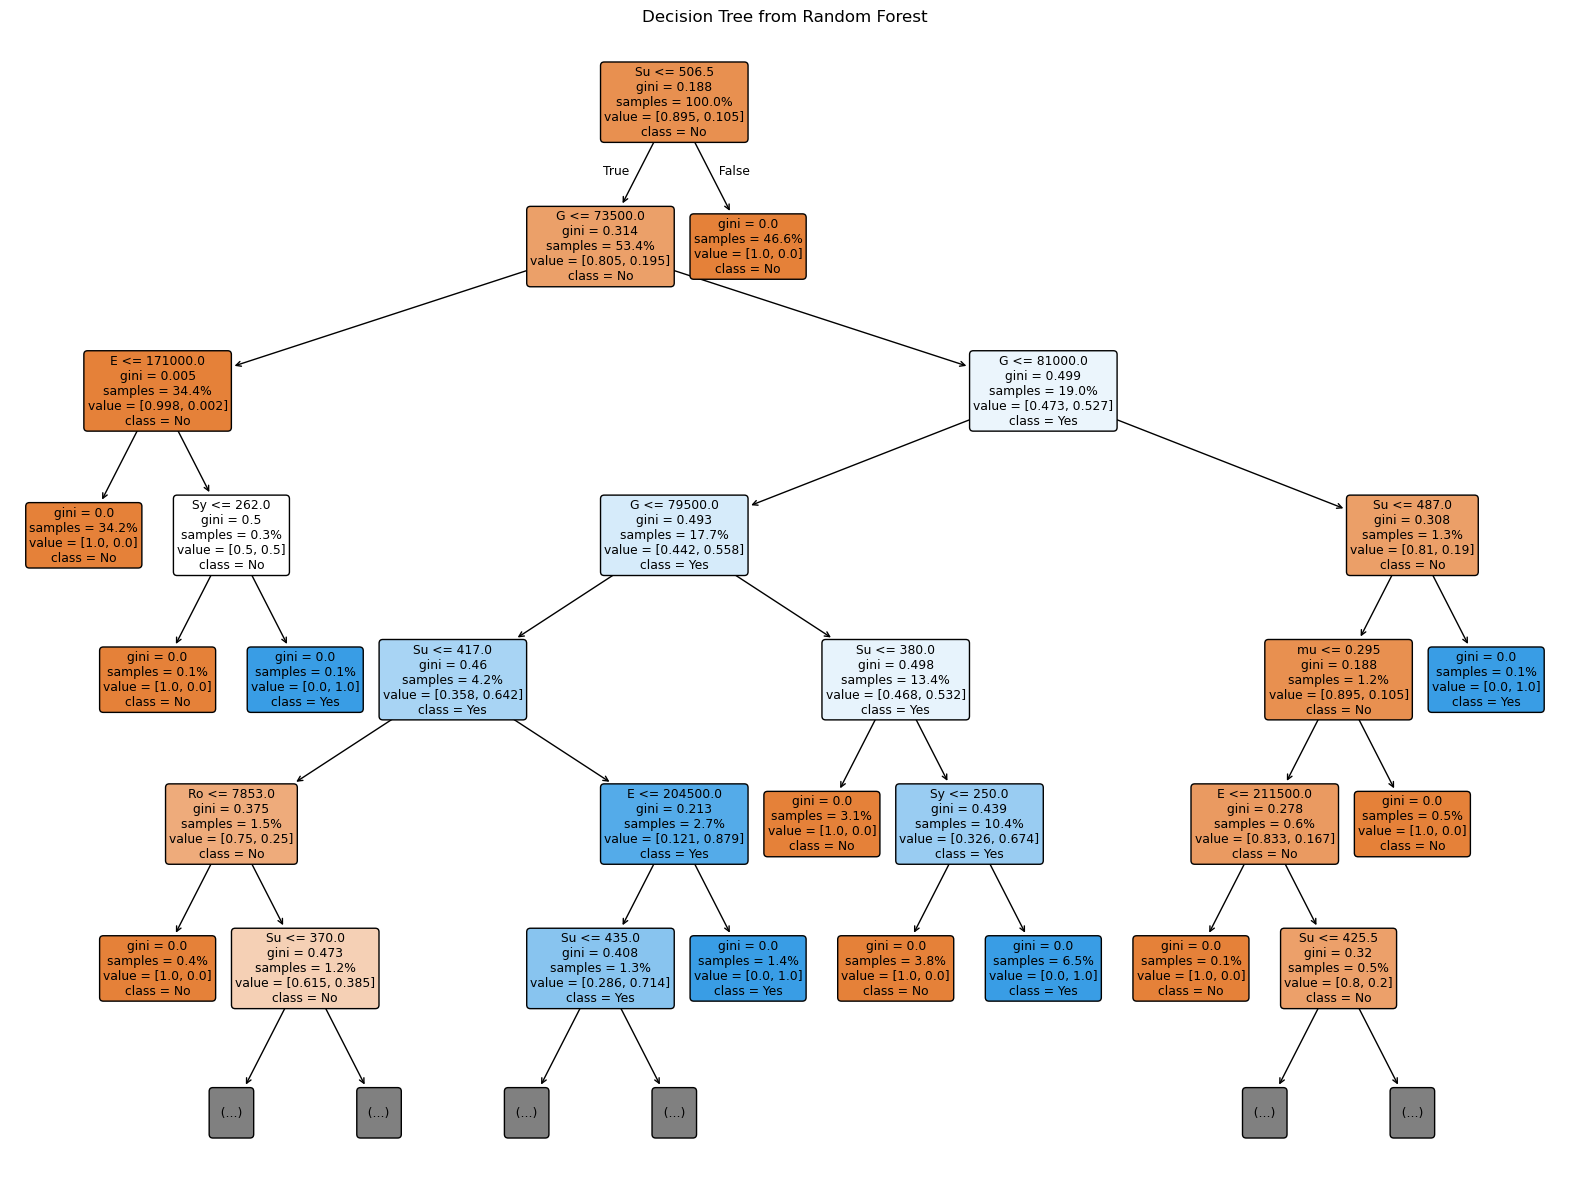

In [5]:
# Visualize one of the decision trees from the trained random forest.
from sklearn.tree import plot_tree

# Pick one tree from the random forest ensemble.
tree = model.estimators_[1]  

plt.figure(figsize=(20, 15))
plot_tree(tree, feature_names = X.columns, max_depth = 6,  filled=True, rounded=True,  class_names=['No', 'Yes'], proportion = True)
plt.title("Decision Tree from Random Forest")
plt.savefig("Decision Tree from Random Forest.png", dpi=300) 
plt.show()

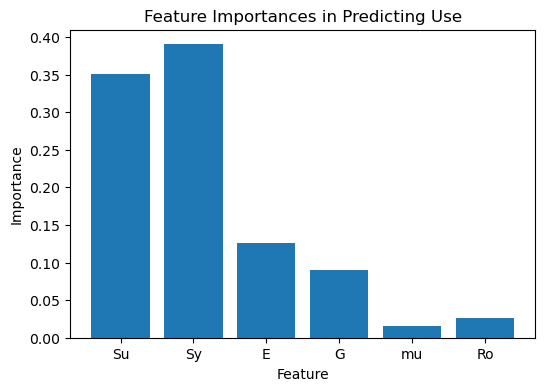

Su: 0.35
Sy: 0.39
E: 0.13
G: 0.09
mu: 0.02
Ro: 0.03


In [7]:
# Visualize feature importances as determined by the random forest model.
import matplotlib.pyplot as plt

# Get feature importances from the trained model.
importances = model.feature_importances_
feature_names = X.columns

# Create a bar plot of feature importances.
plt.figure(figsize=(6, 4))
plt.bar(feature_names, importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title("Feature Importances in Predicting Use")
plt.savefig("Feature Importances in Predicting Use.png", dpi=300)
plt.show()

# Print feature importances for clarity.
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.2f}")

In [7]:
# Define a function to recommend materials based on input mechanical properties and a tolerance.
def material_recommend_for_selection(input_values, tolerance=0.05):
    inp = pd.DataFrame([input_values])
    out = model.predict(inp)

    if out[0] == 0:
        return "No material suitable for selection"
    else:
        # Filter the DataFrame for materials within the tolerance range for each property.
        filtered_df = df[
            (df['Su'].between(input_values['Su'] * (1 - tolerance), input_values['Su'] * (1 + tolerance))) &
            (df['Sy'].between(input_values['Sy'] * (1 - tolerance), input_values['Sy'] * (1 + tolerance))) &
            (df['E'].between(input_values['E']   * (1 - tolerance), input_values['E'] * (1 + tolerance)))  &
            (df['G'].between(input_values['G']   * (1 - tolerance), input_values['G'] * (1 + tolerance)))  &
            (df['mu'].between(input_values['mu'] * (1 - tolerance), input_values['mu'] * (1 + tolerance))) &
            (df['Ro'].between(input_values['Ro'] * (1 - tolerance), input_values['Ro'] * (1 + tolerance)))
        ]

        # Get unique material names where 'Use' is True.
        m = list(filtered_df[filtered_df['Use'] == True]['Material'].unique())

        return f"Materials suitable for selection: {m if m else 'None found'}"

# Example: Recommend materials for beams, construction frames, structural weldments
mech_prop = { 
    'Su': 410,     # Ultimate tensile strength (MPa)
    'Sy': 265,     # Yield strength (MPa)
    'E': 206000,   # Young’s modulus (MPa)
    'G': 80000,    # Shear modulus (MPa)
    'mu': 0.30,    # Poisson’s ratio
    'Ro': 7850     # Density (kg/m³)
}
material_recommend_for_selection(mech_prop)

"Materials suitable for selection: ['ISO EN S275JR ', 'ISO EN S275J2G3 ', 'ISO EN S275J2HG3 ', 'ISO EN SPT410 ', 'DIN DIN HII ', 'DIN DIN St44-2 ', 'DIN DIN St44.0 ', 'DIN DIN St44-3 ', 'CSN CSN 11120 ', 'CSN CSN 11418 ', 'GOST Steel ST4KP GOST 380-94 ', 'GOST Steel ST4PS GOST 380-94 ', 'GOST Steel ST4SP GOST 380-94 ', 'GOST Steel S285 GOST 27772-88 ', 'GOST Steel 25 GOST 1050-88 Annealing or high tempering', 'NF NF A42CP ', 'NF NF E28-2 ', 'NF NF E28-4 ']"

In [8]:
# Example: Recommend materials for automotive panels, cold-formed shapes
mech_prop = {
    'Su': 386,
    'Sy': 284,
    'E': 207000,
    'G': 79000,
    'mu': 0.30,
    'Ro': 7860
}
material_recommend_for_selection(mech_prop)

"Materials suitable for selection: ['ANSI Steel SAE 1015 annealed', 'ANSI Steel SAE 1020 annealed', 'NF NF E28-2 ']"

In [9]:
# Example: Recommend materials for shafts, pins, gears (when surface-hardened).
mech_prop = {
    'Su': 440,
    'Sy': 275,
    'E': 206000,
    'G': 80000,
    'mu': 0.30,
    'Ro': 7860
}
material_recommend_for_selection(mech_prop)

"Materials suitable for selection: ['ANSI Steel SAE 1117 annealed', 'ANSI Steel SAE 1118 annealed', 'ISO EN 16Mo3 ', 'DIN DIN St44.0 ', 'DIN DIN Ck10 case-hardened', 'DIN DIN 15Mo3 ', 'DIN DIN X6Cr17 ', 'BS BS CFS6NBK ', 'CSN CSN 11448 ', 'CSN CSN 11453 ', 'CSN CSN 13030 ', 'CSN CSN 15020 ', 'CSN CSN 16329 ', 'CSN CSN 17040 normalized', 'CSN CSN 17125 normalized', 'GOST Steel 25 GOST 1050-88 normalized', 'GOST Steel 20G GOST 1050-88 normalized', 'NF NF XC18 ', 'NF NF 15D3 ']"